In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_data(path):
    data = np.genfromtxt(path, delimiter=',')
    return data[:,:-1], data[:,-1]

In [3]:
def train_test_split(X, y, ratio=0.8):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    l = int(X.shape[0] * ratio)
    return X[indices[:l]], y[indices[:l]], X[indices[l:]], y[indices[l:]]

In [4]:
def print_precision_recall(y_pred, y_test):
    classes = np.unique(y_test)
    correct = y_pred[y_test == y_pred]
    incorrect = y_pred[y_test != y_pred]

    for c in range(len(classes)):

        tp = len(correct[correct == classes[c]])
        fp = len(incorrect[incorrect == classes[c]])
        fn = len(incorrect) - fp
        
        print("class: {c}, precision: {p}, recall: {r}".format(c=classes[c], p=tp/(tp+fp), r=tp/(tp+fn)))

In [5]:
def sigmoid_loss(M, res='both'):
    if res == 'both':
        return 2 / (1 + np.exp(M)), -2 * np.exp(M) / np.power(1 + np.exp(M), 2)
    elif res == 'fun':
        return 2 / (1 + np.exp(M))
    return -2 * np.exp(M) / np.power(1 + np.exp(M), 2)

In [6]:
def log_loss(M, res='both'):
    if res == 'both':
        return np.log2(1 + np.exp(-M)), -np.exp(-M) / np.log(2) / (1 + np.exp(-M))
    elif res == 'fun':
        return np.log2(1 + np.exp(-M))
    return -np.exp(-M) / np.log(2) / (1 + np.exp(-M))

In [7]:
class GradientDescent:
    def __init__(self, alpha, tau=1e-2, threshold=1e-2, loss=sigmoid_loss):
        if alpha <= 0:
            raise ValueError("alpha should be positive")
        if tau <= 0:
            raise ValueError("tau should be non-negative")
        if threshold <= 0:
            raise ValueError("threshold should be positive")
            
        self.alpha = alpha
        self.tau = tau
        self.threshold = threshold
        self.loss = loss
        
    def fit(self, X_, y):
        n = len(y)
        X = np.concatenate((-np.ones((n,1)), X_), axis=1)
        
        self.weights = np.random.rand(X.shape[1])/n - 1/(2*n)
        weights_prev = self.weights.copy()
        self.weights -= self.alpha * self.tau * self.weights + self.alpha * \
                        np.sum(self.loss(np.inner(self.weights, X)*y, res='grad')[:,np.newaxis] * X * y[:,np.newaxis], axis=0)
        
        self.errors = [np.sum(self.loss(np.inner(self.weights, X)*y, res='fun'))]
            
        while np.abs(weights_prev - self.weights).sum() > self.threshold:          
            weights_prev = self.weights.copy()
            self.weights -= self.alpha * self.tau * self.weights + self.alpha * \
                        np.sum(self.loss(np.inner(self.weights, X)*y, res='grad')[:,np.newaxis] * X * y[:,np.newaxis], axis=0)
            self.errors.append(np.sum(self.loss(np.inner(self.weights, X)*y, res='fun')))
            
        return self.errors
    
    def predict(self, X):
        return np.sign(np.inner(self.weights,np.concatenate((-np.ones((len(X),1)), X), axis=1)))

In [8]:
class SGD:
    def __init__(self, alpha, tau=1e-2, loss=log_loss, k=1, n_iter=100):
        if alpha <= 0:
            raise ValueError("alpha should be positive")
        if tau <= 0:
            raise ValueError("tau should be non-negative")
        if k <= 0 or not isinstance(k, int):
            raise ValueError("k should be a positive integer")
        if n_iter <= 0 or not isinstance(n_iter, int):
            raise ValueError("n_iter should be a positive integer")
            
        self.k = k
        self.n_iter = n_iter
        self.alpha = alpha
        self.tau = tau
        self.loss = loss
        
    def fit(self, X_, y_):
        n = len(y_)
        eta = 1/n
        X = np.concatenate((-np.ones((n,1)), X_), axis=1)
        indeces = np.arange(n)
        np.random.shuffle(indeces)
        X = X[indeces]
        y = y_.copy()[indeces]
        self.weights = np.random.rand(X.shape[1])/n - 1/(2*n)
        
        Q = np.sum(self.loss(np.inner(self.weights, X)*y, res='fun'))
        self.errors = [Q]
        
        for i in range(self.n_iter):          
            start = i * self.k % n
            end = (i + 1) * self.k % n
            batch = X[:(i+1)*self.k] if start < end else np.concatenate((X[end:], X[:start]))
            y_batch = y[:(i+1)*self.k] if start < end else np.concatenate((y[end:], y[:start]))
            
            current_loss = np.sum(self.loss(np.inner(self.weights, batch)*y_batch, res='fun'))
            
            self.weights -= self.alpha * self.tau * self.weights + self.alpha * np.sum(self.loss(
                    np.inner(self.weights, batch)*y_batch, res='grad')[:,np.newaxis] * batch * y_batch[:,np.newaxis], axis=0)
                    
            Q = (1 - eta) * Q + eta * current_loss
            self.errors.append(Q)
            
        return self.errors
    
    def predict(self, X):
        return np.sign(np.inner(self.weights,np.concatenate((-np.ones((len(X),1)), X), axis=1))) 

In [9]:
X, y = read_data('pima-indians-diabetes.csv')
X = (X - X.mean(axis=0)) / X.std(axis=0) # scaling
y[y == 0] = -1

X_train, y_train, X_test, y_test = train_test_split(X, y)

In [27]:
gd = GradientDescent(alpha=0.01)

In [11]:
sgd = SGD(alpha=0.01, n_iter=1000)

In [30]:
tmp = gd.weights.copy()

In [31]:
tmp

array([  8.42844658,   4.06560658,  11.27150017,  -1.39796972,
        -1.34944519,   3.65810914,   7.19306574,   6.25000594,  -0.90984987])

In [33]:
gd.weights

array([  8.42844407,   4.06560521,  11.2714966 ,  -1.39796934,
        -1.34944484,   3.65810803,   7.1930635 ,   6.25000404,  -0.90984935])

In [32]:
gd_errors = gd.fit(X_train, y_train)

In [13]:
sgd_errors = sgd.fit(X_train, y_train)

In [14]:
print_precision_recall(gd.predict(X_test), y_test)

class: -1.0, precision: 0.8165137614678899, recall: 0.8557692307692307
class: 1.0, precision: 0.6666666666666666, recall: 0.6


In [15]:
print_precision_recall(sgd.predict(X_test), y_test)

class: -1.0, precision: 0.8137254901960784, recall: 0.7980769230769231
class: 1.0, precision: 0.5961538461538461, recall: 0.62


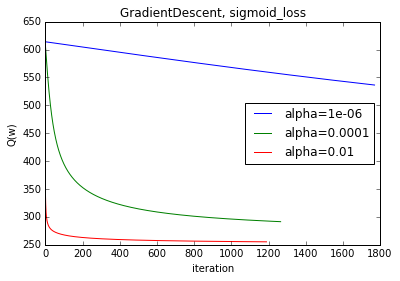

In [16]:
fig, ax = plt.subplots()

for alpha, threshold in zip([1e-6, 1e-4, 1e-2], [5e-4, 3e-3, 1e-2]):
    gd = GradientDescent(alpha=alpha, threshold=threshold, loss=sigmoid_loss)
    errors = gd.fit(X_train, y_train)
    ax.plot(range(len(errors)), errors, label="alpha={a}".format(a=alpha))
    
ax.legend(loc=0)
ax.set_xlabel('iteration')
ax.set_ylabel('Q(w)')
ax.set_title('GradientDescent, sigmoid_loss')

Problem with alpha=1: with any reasonable threshold it takes only two iterations of cycle for both loss functions.

For log_loss some mystery with alpha=1e-2 too: either one iteration or really big number.

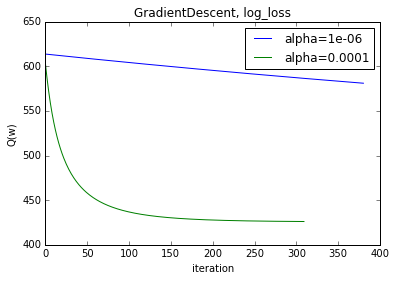

In [17]:
fig, ax = plt.subplots()

for alpha, threshold in zip([1e-6, 1e-4], [7e-4, 2e-3]):
    gd = GradientDescent(alpha=alpha, threshold=threshold, loss=log_loss)
    errors = gd.fit(X_train, y_train)
    ax.plot(range(len(errors)), errors, label="alpha={a}".format(a=alpha))
    
ax.legend(loc=0)
ax.set_xlabel('iteration')
ax.set_ylabel('Q(w)')
ax.set_title('GradientDescent, log_loss')

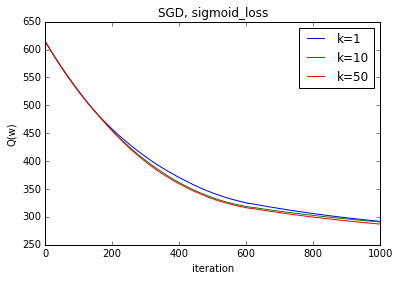

In [18]:
fig, ax = plt.subplots()

for k in [1, 10, 50]:
    sgd = SGD(alpha=0.5, n_iter=1000, loss=sigmoid_loss)
    errors = sgd.fit(X_train, y_train)
    ax.plot(range(len(errors)), errors, label="k={k}".format(k=k))
    
ax.legend(loc=0)
ax.set_xlabel('iteration')
ax.set_ylabel('Q(w)')
ax.set_title('SGD, sigmoid_loss')

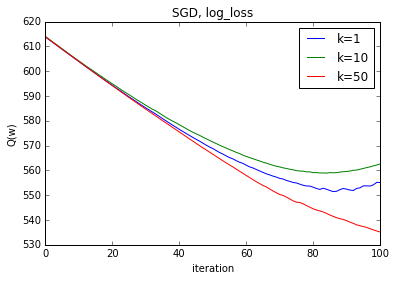

In [19]:
fig, ax = plt.subplots()

for k in [1, 10, 50]:
    sgd = SGD(alpha=0.5, n_iter=100, loss=log_loss)
    errors = sgd.fit(X_train, y_train)
    ax.plot(range(len(errors)), errors, label="k={k}".format(k=k))
    
ax.legend(loc=0)
ax.set_xlabel('iteration')
ax.set_ylabel('Q(w)')
ax.set_title('SGD, log_loss')